# Problem 1

In [1]:
from math import factorial
from scipy import integrate
import numpy as np
np.set_printoptions(suppress=True)

In [2]:
N = 5

In [3]:
# K array has the coefficients of densities

K = np.zeros([N,N])
numerator = factorial(N)
for i in range(N):
    for j in range(N):
        if i == j:
            m = i + 1
            K[i][j] = numerator / (factorial(m - 1) * factorial(N - m))
        if i < j:
            m = i + 1
            n = j + 1
            K[i][j] = numerator / (factorial(m - 1) * factorial(n - m - 1) * factorial(N - n))  

In [4]:
print('Coefficients of Densities are: \n', K)

Coefficients of Densities are: 
 [[  5.  20.  60.  60.  20.]
 [  0.  20.  60. 120.  60.]
 [  0.   0.  30.  60.  60.]
 [  0.   0.   0.  20.  20.]
 [  0.   0.   0.   0.   5.]]


In [5]:
# Distribution and density functions of Noise
# Noise follows Uniform density

F = lambda z: (1 + z) / 2
f = lambda z: 0.5

In [6]:
# Integrands to calculate the expectations for Covariance matrix entries
# Off diagonal elements uses Joint densities of Z(i) and Z(j)
# Diagonal elements uses density function of Z(i)

diag_density_integrand = lambda z, i: K[i - 1][i - 1] * (z ** 2) * ((F(z)) ** (i - 1)) * ((1 - F(z)) ** (N - i)) * f(z)
off_diag_density_integrand = lambda z2, z1, i, j: K[i - 1][j - 1] * z1 * z2 * ((F(z1)) ** (i - 1)) * ((F(z2) - F(z1)) ** (j - i - 1)) * ((1 - F(z2)) ** (N - j)) * f(z1) * f(z2)

In [7]:
# H matrix calculation

H = np.zeros([N, N])
for i in range(1, N + 1):
    for j in range(i , N + 1):
        if i == j:
            H[i - 1][j - 1] = integrate.quad(diag_density_integrand, -1, 1, args = (i,))[0]
        else:
            H[i - 1][j - 1] = integrate.dblquad(off_diag_density_integrand, -1, 1, lambda z1: z1, 1, args = (i, j,))[0]
        H[j - 1][i - 1] = H[i - 1][j - 1]

In [8]:
print('Covariance Matrix is: \n', H)

Covariance Matrix is: 
 [[ 0.52380952  0.28571429  0.04761905 -0.19047619 -0.42857143]
 [ 0.28571429  0.23809524  0.0952381  -0.04761905 -0.19047619]
 [ 0.04761905  0.0952381   0.14285714  0.0952381   0.04761905]
 [-0.19047619 -0.04761905  0.0952381   0.23809524  0.28571429]
 [-0.42857143 -0.19047619  0.04761905  0.28571429  0.52380952]]


In [9]:
# Calculating the Order Statistics Coefficients

e = np.ones([N, 1])
alpha = np.matmul(np.linalg.inv(H), e) / (np.dot(np.transpose(e), np.matmul(np.linalg.inv(H), e)))
alpha = np.squeeze(alpha)

In [10]:
print('Order Statistics coefficients for MSE are: ', alpha)

Order Statistics coefficients for MSE are:  [ 0.5 -0.   0.  -0.   0.5]


# Problem 2 

In [11]:
!pip install bm3d
!pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [12]:
import bm3d
from matplotlib import image
from matplotlib import pyplot
from skimage.color import rgb2gray

In [13]:
# Function that adds random gaussian noise of a given sigma

def AddGaussianNoise(image, mean, sigma):
    return image + np.random.normal(mean, sigma, image.shape)

In [14]:
# Function that returns the bm3d denoised image from either of the stages

def bm3d_outputs(image, sigma, stage):
    if stage == 1:
        return bm3d.bm3d(image, sigma_psd = sigma, stage_arg = bm3d.BM3DStages.HARD_THRESHOLDING)
    elif stage == 2:
        return bm3d.bm3d(image, sigma_psd = sigma, stage_arg = bm3d.BM3DStages.ALL_STAGES)

In [15]:
# Function that calculates the Mean Square Error between given two images

def MeanSquareError(input_image, output_image):
    return np.mean((input_image - output_image) ** 2)

### 1 Mean Square Error after 1st stage and 2nd stage

In [16]:
lighthouse = image.imread('/media/beluga/Data/IISc AI/AIP lectures/AIP2023-Assignments/Assignment-3/lighthouse2.bmp')

In [17]:
# Grayscaling

grayscaled_image = 255 * rgb2gray(lighthouse)

In [18]:
# Clipping the pixel values between 0 and 255

noisy_image = AddGaussianNoise(grayscaled_image, 0, 10)
noisy_image = np.clip(noisy_image, 0, 255)

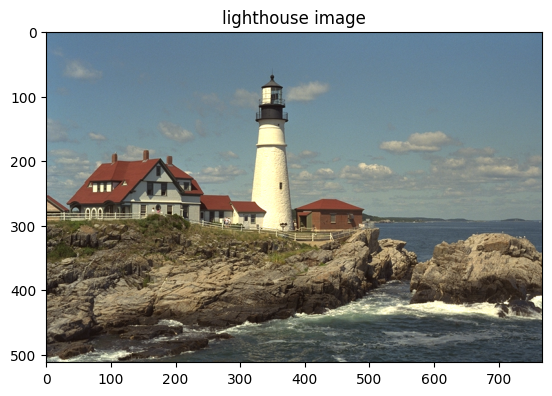

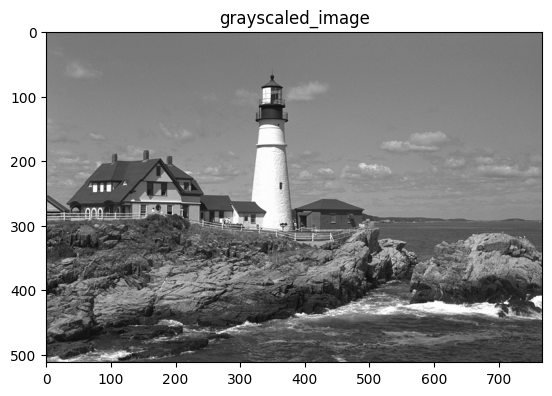

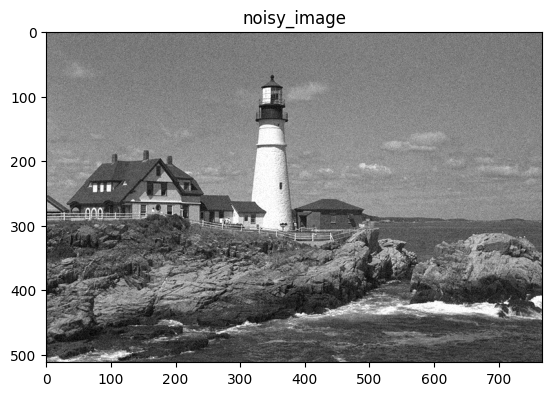

In [19]:
# Visualizing the images

# Original
pyplot.imshow(lighthouse)
pyplot.title('lighthouse image')
pyplot.show()

# Grayscaled
pyplot.imshow(grayscaled_image, cmap = 'gray')
pyplot.title('grayscaled_image')
pyplot.show()

# Noisy
pyplot.imshow(noisy_image, cmap = 'gray')
pyplot.title('noisy_image')
pyplot.show()

In [20]:
# Denoised images after 1st stage and 2nd stage
stage1_output = bm3d_outputs(noisy_image, 10, 1)
stage2_output = bm3d_outputs(noisy_image, 10 , 2)

# MSE  
print('Mean Square Error after 1st stage is: ', MeanSquareError(grayscaled_image, stage1_output))
print('Mean Square Error after 2nd stage is: ', MeanSquareError(grayscaled_image, stage2_output))

Mean Square Error after 1st stage is:  32.583559299947694
Mean Square Error after 2nd stage is:  27.82911631733177


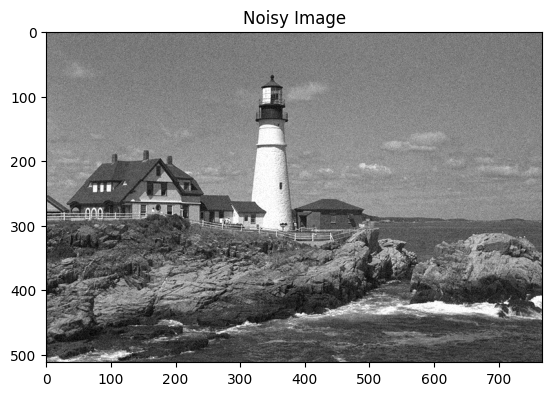

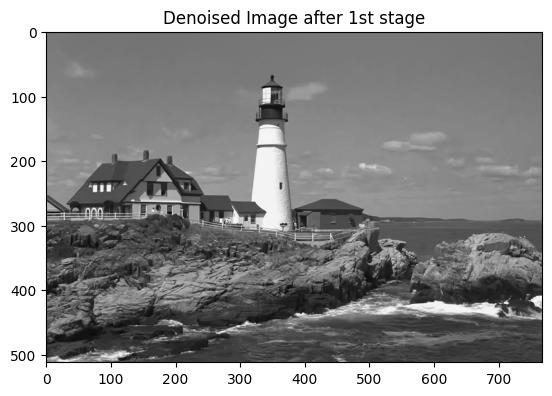

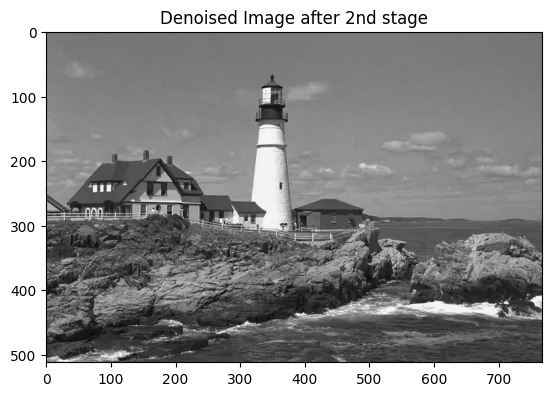

In [21]:
# Comparing 1st stage and 2nd stage denoised images

# Noisy Image
pyplot.imshow(noisy_image, cmap = 'gray')
pyplot.title('Noisy Image')
pyplot.show()

# After 1st Stage
pyplot.imshow(stage1_output, cmap = 'gray')
pyplot.title('Denoised Image after 1st stage')
pyplot.show()

# After 2nd Stage
pyplot.imshow(stage2_output, cmap = 'gray')
pyplot.title('Denoised Image after 2nd stage')
pyplot.show()

### 2 Mean Square Error vs Variance

In [22]:
# Mean Square Errors with varying Sigmas

Variances = []
MSE = []
for i in range(1, 20):
    Variances.append(i ** 2)
    MSE.append(MeanSquareError(grayscaled_image, bm3d_outputs(noisy_image, i, 2)))

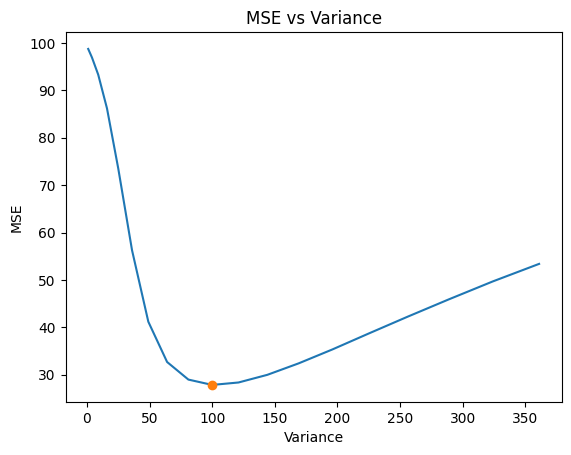

In [23]:
#Plotting the variation of MSE wrt Variance

pyplot.plot(Variances, MSE)
pyplot.xlabel('Variance')
pyplot.ylabel('MSE')
pyplot.title('MSE vs Variance')
pyplot.plot(Variances[np.argmin(MSE)], MSE[np.argmin(MSE)], marker='o')
pyplot.show()

### 3 Comparison of Mean Square Error with Wiener filter and with Hardthresholding again

In [24]:
# Mean Square Error with Wiener filter and with Hardthresholding Estimate

stage1_output = bm3d_outputs(noisy_image, 10, 1)
WithWiener = bm3d_outputs(noisy_image, 10 , 2)
WithHardThreshold = bm3d_outputs(stage1_output, 10 , 1)
print('Mean Square Error with Wiener filter: ', MeanSquareError(grayscaled_image, WithWiener))
print('Mean Square Error with Hardthresholding again: ', MeanSquareError(grayscaled_image, WithHardThreshold))

Mean Square Error with Wiener filter:  27.82911597093022
Mean Square Error with Hardthresholding again:  62.90944261283917


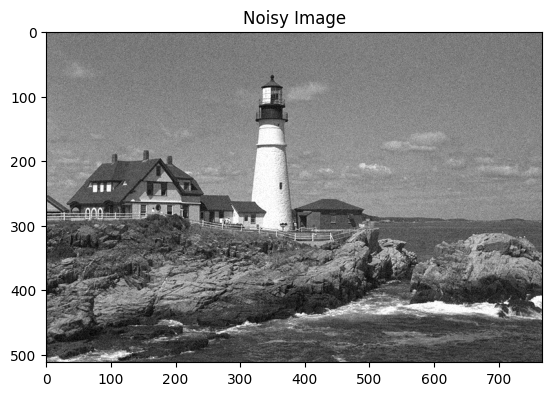

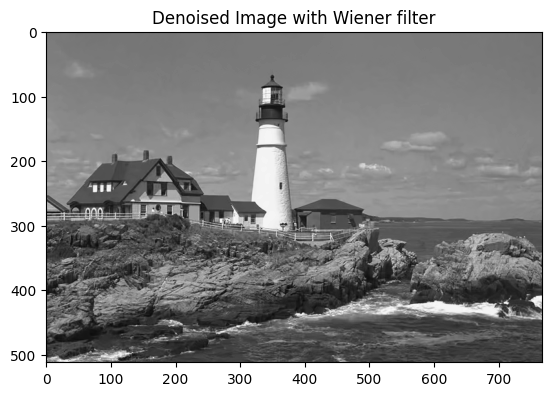

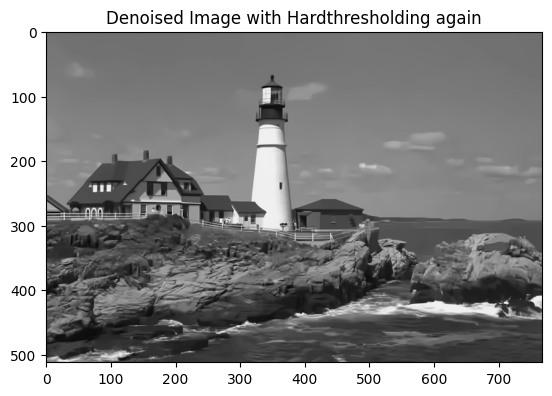

In [25]:
# Plotting the denoised images obtained in both ways

# Noisy Image
pyplot.imshow(noisy_image, cmap = 'gray')
pyplot.title('Noisy Image')
pyplot.show()

# After Wiener filter
pyplot.imshow(WithWiener, cmap = 'gray')
pyplot.title('Denoised Image with Wiener filter')
pyplot.show()

# After Hardthresholding again
pyplot.imshow(WithHardThreshold, cmap = 'gray')
pyplot.title('Denoised Image with Hardthresholding again')
pyplot.show()